In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import scipy.stats as stats
from tqdm import tqdm
from scipy.optimize import root_scalar
from scipy.sparse.linalg import eigsh

import punct_utils as utils

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

# Phase transition position

In [2]:
n = 10000
ks = np.arange(2)
cs = np.linspace(0.01, 1.5, 100)
alphas = np.linspace(0.01, 1, 100)

a, b = 1e-5, 20
pht = np.zeros((len(ks), len(cs), len(alphas)))
for k, kk in enumerate(tqdm(ks)):
    for i, c in enumerate(cs):
        p = int(c*n)
        for j, alpha in enumerate(alphas):
            L = int(alpha*n)
            psi = utils.nu(L, 2*np.arange(n)*np.pi/n)
            func = lambda mun: p*np.mean((psi/((mun**2+1)*psi[kk]-psi))**2)-1
            if func(a)*func(b) < 0:
                res = root_scalar(func, method='brentq', bracket=[a, b])
                pht[k, i, j] = res.root if res.converged else np.nan
            else:
                pht[k, i, j] = np.nan

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.61s/it]


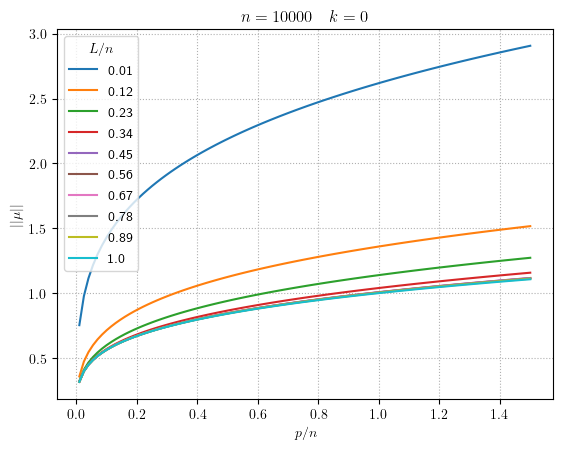

In [3]:
kk = 0
idx = np.linspace(0, 99, 10).astype(int)

plt.plot(cs, pht[kk, :, idx].T)
plt.grid(ls=':')
plt.legend(np.round(alphas[idx], 2), title="$L/n$")
plt.xlabel("$p/n$")
plt.ylabel("$|| \\mu ||$")
plt.title("$n = {} \quad k = {}$".format(n, kk))
plt.show()

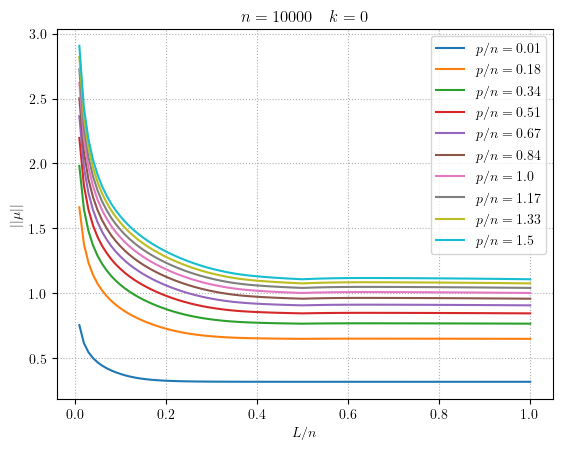

In [4]:
for i in idx:
    plt.plot(alphas, pht[kk, i], label="$p/n = {}$".format(np.round(cs[i], 2)))
plt.grid(ls=':')
plt.xlabel("$L/n$")
plt.ylabel("$|| \\mu ||$")
plt.title("$n = {} \quad k = {}$".format(n, kk))
plt.legend()
plt.show()

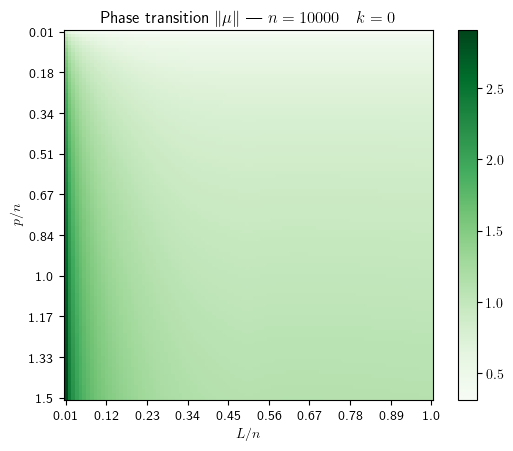

In [5]:
plt.colorbar(plt.imshow(pht[kk], cmap='Greens'))
plt.xticks(idx, np.round(alphas[idx], 2))
plt.yticks(idx, np.round(cs[idx], 2))
plt.xlabel("$L/n$")
plt.ylabel("$p/n$")
plt.title("Phase transition $\\| \\mu \\|$ | $n = {} \quad k = {}$".format(n, kk))
plt.show()

# Alignment $-\zeta_k$

In [7]:
n = 2500
p = 250
L = 250
mask = 'toeplitz'

setting = "$n = {} \quad p = {} \quad L = {} \quad$({} mask)".format(n, p, L, mask)

n_eigvecs = 6

## Theoretical alignments

In [8]:
mur = np.linspace(0.5, 5, 200)

psi, basis = utils.basis(n, L, kind=mask)
psi_k, psi_l = np.meshgrid(psi, psi)
E = np.isclose(psi_k, psi_l)

zeta = np.zeros((len(mur), n))
for i, mu_ in enumerate(tqdm(mur)):
    zeta[i] = (1-p*np.mean((psi_l/((mu_**2+1)*psi_k-psi_l))**2, axis=0))*((mu_**2)/(mu_**2+1))
align = np.maximum(0., zeta)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:22<00:00,  8.90it/s]


## Empirical alignments

In [9]:
pi = np.array([0.5, 0.5])
n_rep = 10
mu_norm_r = np.linspace(0.5, 5, 10)
B = utils.genB(n, L, kind=mask)

In [10]:
emp_align = np.zeros((n_rep, len(mu_norm_r), n_eigvecs))

for i in tqdm(range(n_rep)):
    for j, mu_norm in enumerate(mu_norm_r):
        # Set model
        mu = stats.norm.rvs(size=(p, 1))
        mu = mu_norm*mu/linalg.norm(mu)
        M = np.concatenate([+mu, -mu], axis=1)
        J = utils.getJ(n, pi)
        
        P = M@(J.T)
        Z = stats.norm.rvs(size=(p, n))
        X = Z+P
        K = ((X.T.conj())@X)*B/p
        
        # Empirical eigenspectrum
        eigvals, eigvecs = linalg.eigh(K)
        eigvecs = eigvecs.T
        
        # Empirical alignement
        Fj = basis*(J[:, 0]-J[:, 1])
        
        if mask == 'circulant':
            (spikes_idx, spikes, _, _), _ = utils.get_spikes(n, p, L, mu_norm, tau=psi)
        elif mask == 'toeplitz':
            _, (spikes_idx, spikes, _, _) = utils.get_spikes(n, p, L, mu_norm, tau=psi)
        else:
            raise NotImplementedError(mask)
        
        for kk, k in enumerate(spikes_idx[:n_eigvecs]):
            emp_align[i, j, kk] = np.sum(np.abs(np.sum(Fj[k].conj()*eigvecs[E[k]], axis=-1))**2)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:43<00:00, 46.36s/it]


## Plots

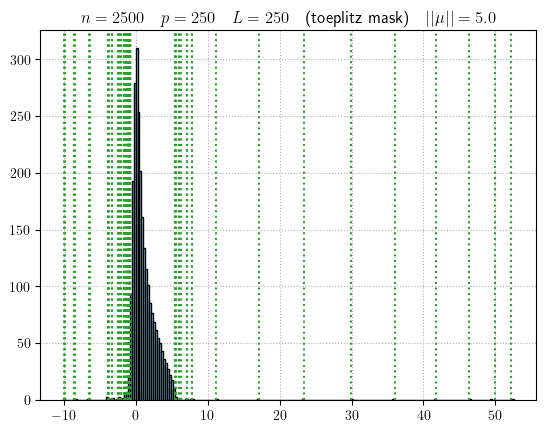

In [11]:
plt.hist(eigvals.flatten(), bins='auto', color='skyblue', edgecolor='black', zorder=2)
ymin, ymax = plt.ylim()
for spike in spikes:
    plt.axvline(spike, ls=':', color='C2')
plt.grid(ls=':')
plt.title(setting+"$\quad || \mu || = {}$".format(mu_norm))
plt.show()

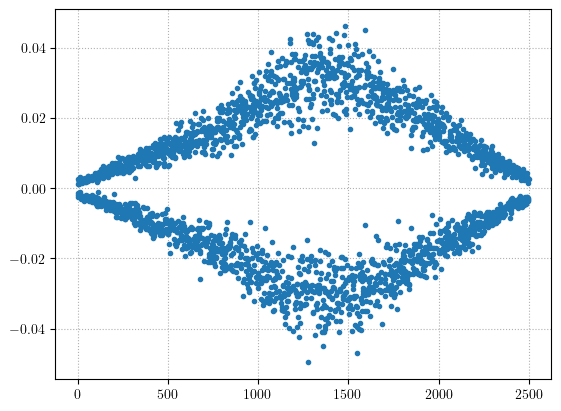

In [12]:
plt.plot(eigvecs[-1], ls='', marker='.')
plt.grid(ls=':')
plt.show()

In [13]:
emp_align_mean = emp_align.mean(axis=0)
emp_align_std = emp_align.std(axis=0)

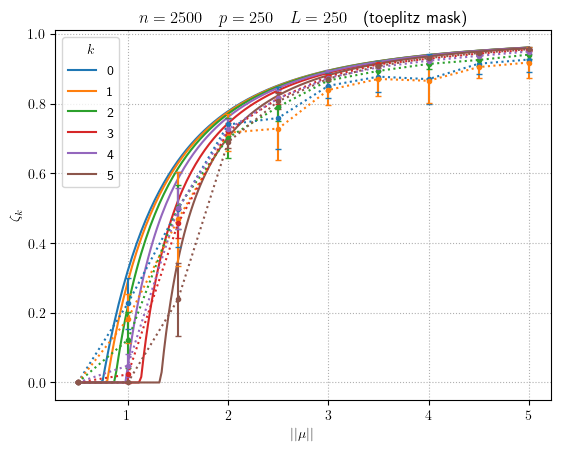

In [14]:
plt.plot(mur, align[:, spikes_idx[:n_eigvecs]], zorder=2)
for i in range(n_eigvecs):
    plt.errorbar(mu_norm_r, emp_align_mean[:, i], yerr=emp_align_std[:, i],
                 ls=':', marker='.', capsize=2, zorder=3, color='C'+str(i))
plt.grid(ls=':')
plt.xlabel("$|| \\mu ||$")
plt.ylabel("$\zeta_k$")
plt.title(setting)
plt.legend(range(n_eigvecs), title="$k$")
plt.show()

## First alignment

In [15]:
dim = 5
first_align = np.zeros((n_rep, len(mu_norm_r), dim))

for i in tqdm(range(n_rep)):
    for j, mu_norm in enumerate(mu_norm_r):
        # Set model
        mu = stats.norm.rvs(size=(p, 1))
        mu = mu_norm*mu/linalg.norm(mu)
        M = np.concatenate([+mu, -mu], axis=1)
        J = utils.getJ(n, pi)
        
        P = M@(J.T)
        Z = stats.norm.rvs(size=(p, n))
        X = Z+P
        K = ((X.T.conj())@X)*B/p
        
        # Empirical eigenspectrum
        eigvals, eigvecs = linalg.eigh(K)
        eigvecs = eigvecs.T
        
        # Empirical alignement
        Fj = basis*(J[:, 0]-J[:, 1])
        
        if mask == 'circulant':
            (spikes_idx, _, _, _), _ = utils.get_spikes(n, p, L, mu_norm, tau=psi)
        elif mask == 'toeplitz':
            _, (spikes_idx, _, _, _) = utils.get_spikes(n, p, L, mu_norm, tau=psi)
        else:
            raise NotImplementedError(mask)
        
        for d in range(min(dim, len(spikes_idx))):
            first_align[i, j, d] = np.abs(np.sum(Fj[spikes_idx[0]].conj()*eigvecs[spikes_idx[d]]))**2
first_align = first_align.cumsum(axis=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:53<00:00, 47.30s/it]


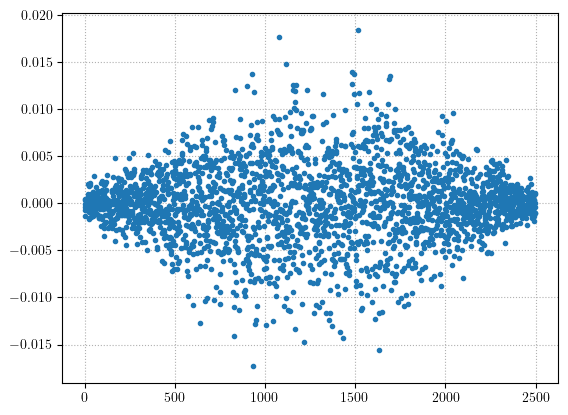

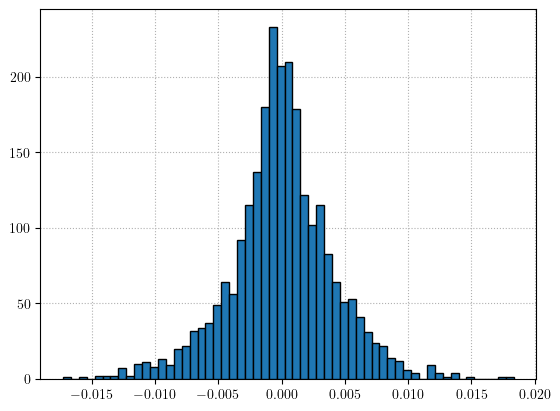

In [16]:
residual = Fj[spikes_idx[0]].copy()
for d in range(dim):
    residual -= np.sum(Fj[spikes_idx[0]].conj()*eigvecs[spikes_idx[d]])*eigvecs[spikes_idx[d]]

plt.plot(residual.real, ls='', marker='.')
plt.grid(ls=':')
plt.show()

plt.hist(residual.real, bins='auto', edgecolor='black', zorder=3)
plt.grid(ls=':')
plt.show()

In [17]:
first_align_mean = first_align.mean(axis=0)
first_align_std = first_align.std(axis=0)

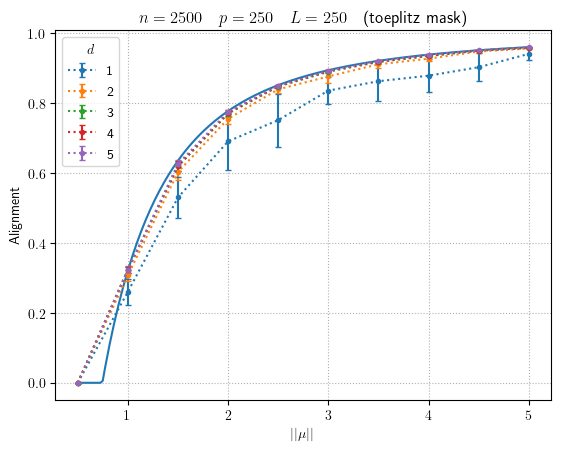

In [18]:
for d in range(dim):
    plt.errorbar(mu_norm_r, first_align_mean[:, d], yerr=first_align_std[:, d],
                 ls=':', marker='.', capsize=2, zorder=3, color='C'+str(d), label=d+1)
plt.plot(mur, align[:, spikes_idx[0]], zorder=2, color='C0')
plt.grid(ls=':')
plt.xlabel("$|| \\mu ||$")
plt.ylabel("Alignment")
plt.title(setting)
plt.legend(title="$d$")
plt.show()